In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
file_path = '/Users/aizixin/Desktop/Processed_E_Pillars_Scaled_Reduced.xlsx'
df = pd.read_excel(file_path)

# Extract features and target variable
X = df.drop(['ROA', 'Instrument'], axis=1)
y = df['ROA']

# Encode categorical variables
label_encoders = {}
for column in X.columns:
    if X[column].dtype == 'object':
        label_encoders[column] = LabelEncoder()
        X[column] = label_encoders[column].fit_transform(X[column])


In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Define hyperparameters according to the provided image
hyperparameters = {
    'LassoRegression': {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1]},
    'RidgeRegression': {'alpha': [0.01, 0.1, 0.5, 1, 2, 10, 20, 30, 100]},
    'KNeighborsRegressor': {'n_neighbors': [5, 10, 15, 20], 'p': [1, 2, 4, 8, 10]},
    'DecisionTreeRegressor': {'max_depth': [5, 10, 15, 20], 'min_samples_leaf': [1, 2, 5], 'min_samples_split': [2, 3]},
    'RandomForestRegressor': {'n_estimators': [200, 400, 500]},
    'AdaBoostRegressor': {'n_estimators': [200, 400, 500], 'learning_rate': [0.001]},
    'MLPRegressor': {'hidden_layer_sizes': [(50, 25), (100,), (50, 50)], 'max_iter': [1000], 'random_state': [42]}
}

In [5]:
# Initialize models with their respective hyperparameters
models_with_hyperparameters = {
    'Linear Regression': (LinearRegression(), {}),
    'Lasso Regression': (Lasso(), hyperparameters['LassoRegression']),
    'Ridge Regression': (Ridge(), hyperparameters['RidgeRegression']),
    'KNeighbors Regressor': (KNeighborsRegressor(), hyperparameters['KNeighborsRegressor']),
    'Decision Tree': (DecisionTreeRegressor(), hyperparameters['DecisionTreeRegressor']),
    'Random Forest': (RandomForestRegressor(), hyperparameters['RandomForestRegressor']),
    'AdaBoost': (AdaBoostRegressor(), hyperparameters['AdaBoostRegressor']),
    'MLP Regressor': (MLPRegressor(), hyperparameters['MLPRegressor'])
}

In [6]:
# Train each model, find the best hyperparameters, and evaluate the performance
results_with_hyperparameters = []
best_models = {}

for name, (model, params) in models_with_hyperparameters.items():
    if params:
        grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=5, error_score='raise')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else:
        best_model = model
        best_model.fit(X_train, y_train)
        best_params = "None"
    
    # Predict and calculate RMSE for both training and testing sets
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    results_with_hyperparameters.append({
        'Model': name,
        'Best Hyperparameters': best_params,
        'RMSE Train': rmse_train,
        'RMSE Test': rmse_test
    })
    
    best_models[name] = best_model

In [7]:
# Create DataFrame for best hyperparameters and RMSE results
results_with_hyperparameters_df = pd.DataFrame(results_with_hyperparameters)
results_with_hyperparameters_df.sort_values(by='RMSE Test', inplace=True)

# Display the results with best hyperparameters and RMSE
print(results_with_hyperparameters_df)

# Print only the best hyperparameters for each model
best_params_df = results_with_hyperparameters_df[['Model', 'Best Hyperparameters']]
print(best_params_df)


                  Model                               Best Hyperparameters  \
5         Random Forest                              {'n_estimators': 200}   
6              AdaBoost      {'learning_rate': 0.001, 'n_estimators': 200}   
1      Lasso Regression                                   {'alpha': 0.001}   
2      Ridge Regression                                     {'alpha': 100}   
3  KNeighbors Regressor                       {'n_neighbors': 20, 'p': 10}   
0     Linear Regression                                               None   
4         Decision Tree  {'max_depth': 5, 'min_samples_leaf': 5, 'min_s...   
7         MLP Regressor  {'hidden_layer_sizes': (50, 25), 'max_iter': 1...   

   RMSE Train  RMSE Test  
5    0.013343   0.007850  
6    0.015359   0.008174  
1    0.015422   0.008177  
2    0.015370   0.008206  
3    0.015311   0.008208  
0    0.015354   0.008726  
4    0.015097   0.008817  
7    0.040861   0.043674  
                  Model                               

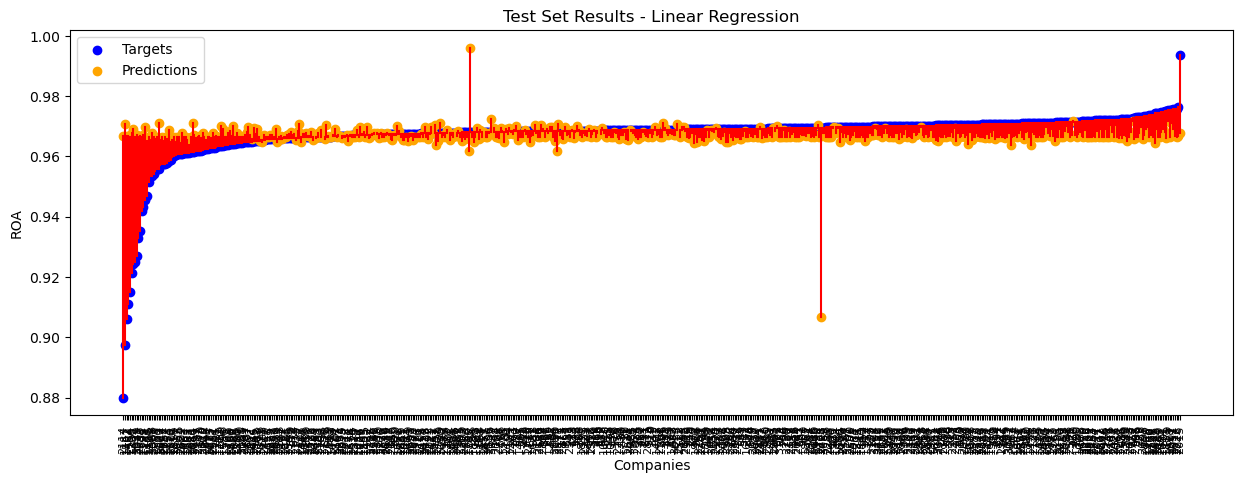

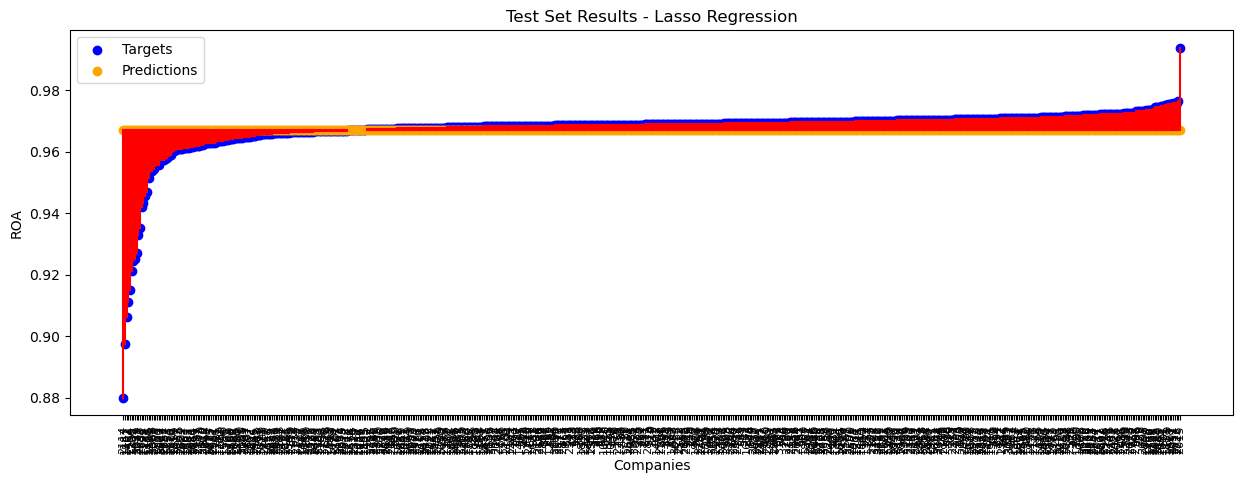

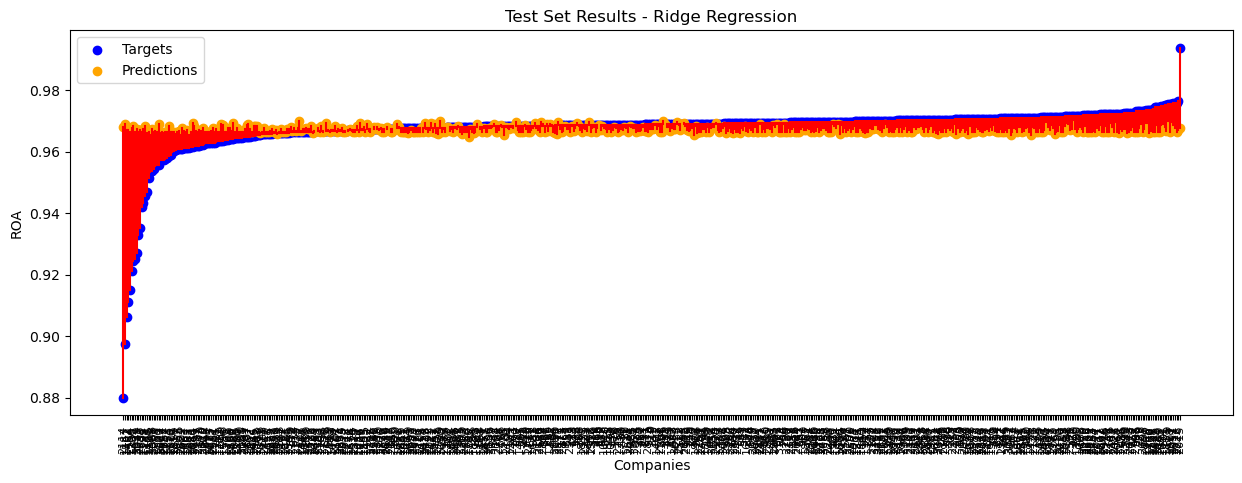

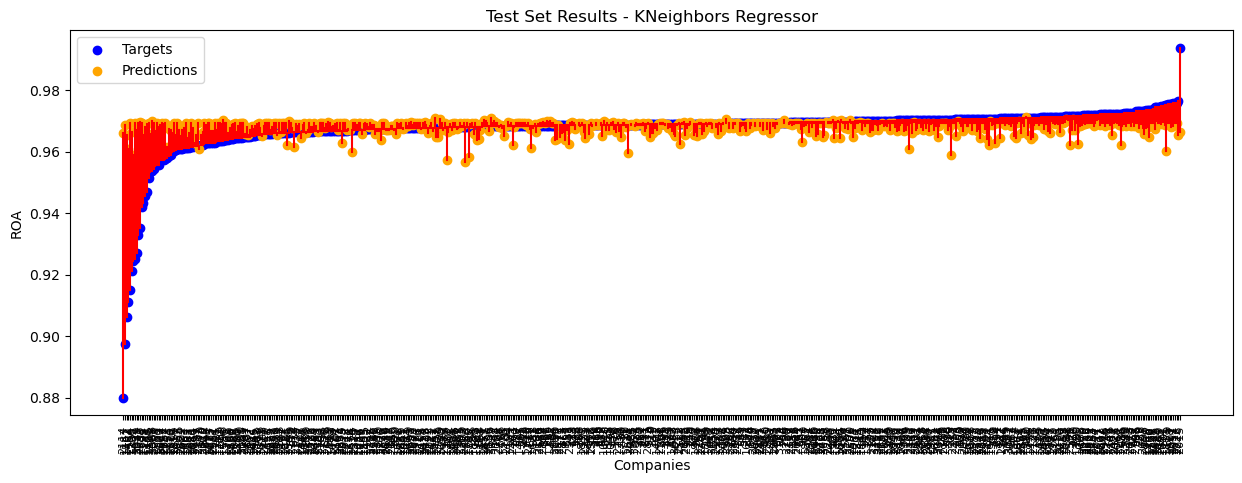

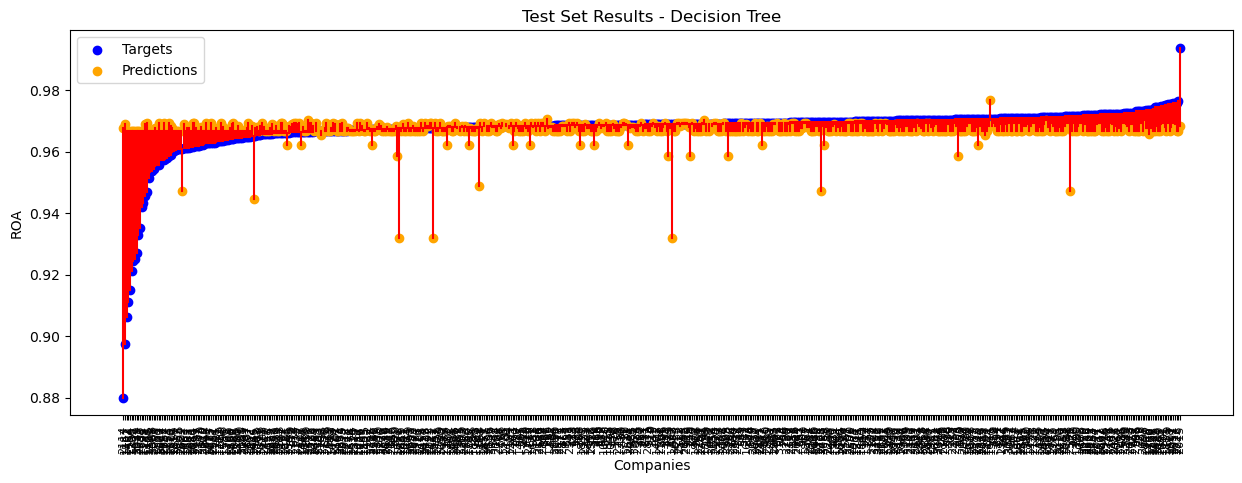

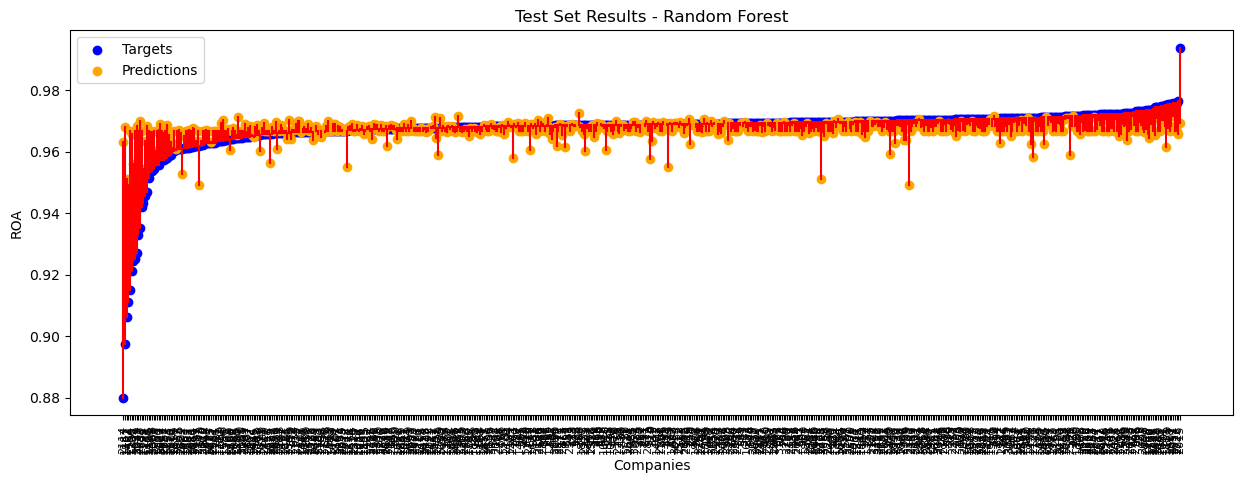

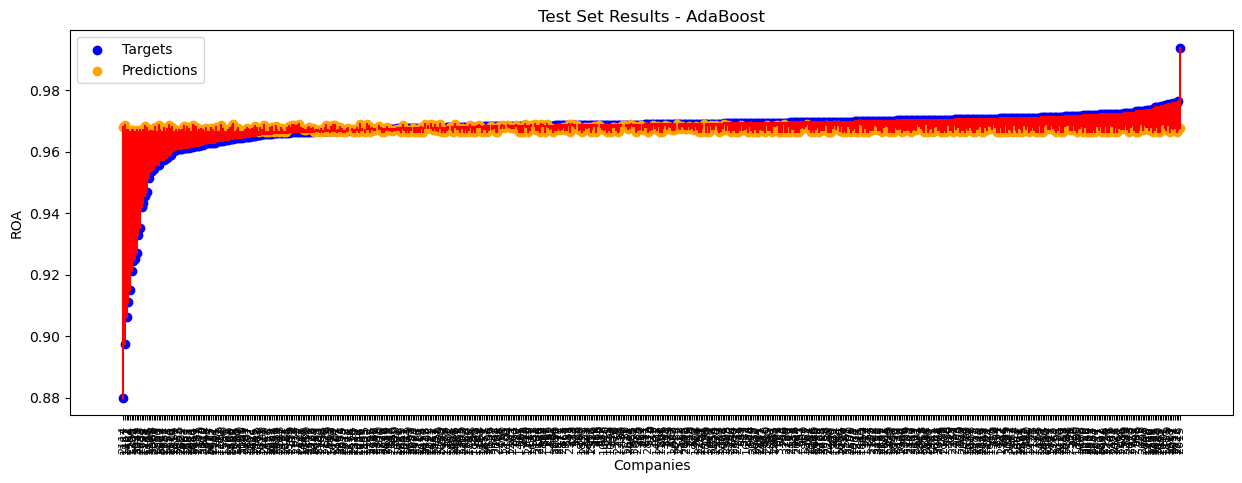

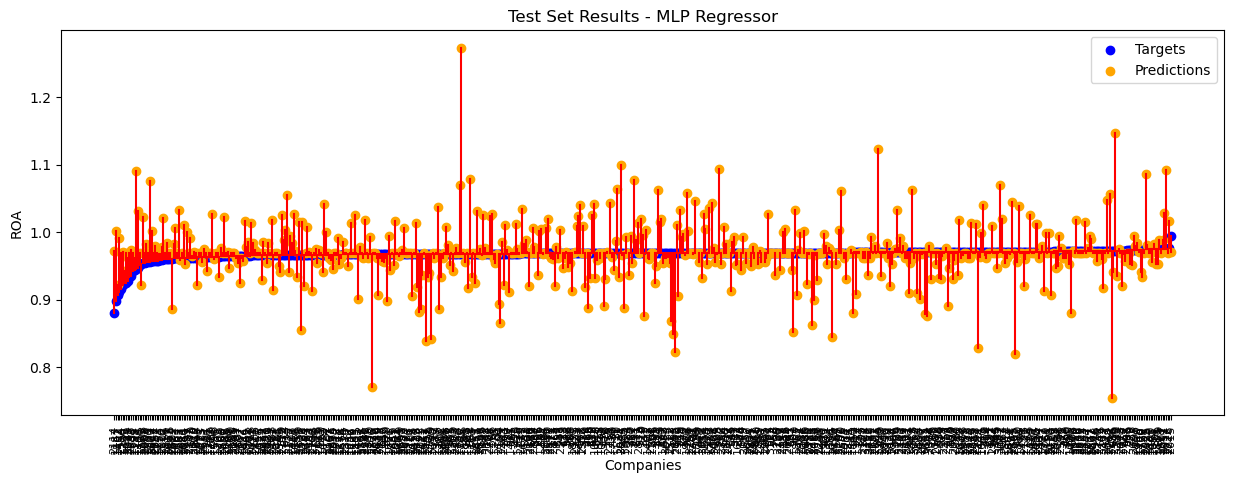

In [8]:
# Function to plot model results with sorted y_test
def plot_model_results(y_test, y_pred, model_name):
    sorted_indices = y_test.argsort()
    y_test_sorted = y_test.iloc[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]

    plt.figure(figsize=(15, 5))
    
    # Actual vs Predicted
    plt.scatter(range(len(y_test_sorted)), y_test_sorted, color='blue', label='Targets')
    plt.scatter(range(len(y_test_sorted)), y_pred_sorted, color='orange', label='Predictions')
    
    # Error bars
    for i in range(len(y_test_sorted)):
        plt.plot([i, i], [y_test_sorted.iloc[i], y_pred_sorted[i]], color='red')
    
    # Labels and title
    plt.xlabel('Companies')
    plt.ylabel('ROA')
    plt.title(f'Test Set Results - {model_name}')
    plt.legend()
    plt.xticks(ticks=range(len(y_test_sorted)), labels=X_test.index[sorted_indices], rotation=90, fontsize=8)
    plt.show()

# Plot results for each model using the best hyperparameters
for name, model in best_models.items():
    y_test_pred = model.predict(X_test)
    plot_model_results(y_test, y_test_pred, name)